In [64]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [65]:
clight=constants.speed_of_light
circumference = line.get_length()

class Ion:
    def __init__(self, name, A, Z, q0, excited_lifetime, hw0):
        m_u = 931.49410242e6  # eV/c^2 -- atomic mass unit
        m_e = 0.511e6  # eV/c^2 -- electron mass
        m_p = 938.272088e6  # eV/c^2 -- proton mass

        self.name = name
        self.A = A
        self.Z = Z
        self.q0 = q0  # e
        self.excited_lifetime = excited_lifetime  # s
        self.hw0 = hw0  # eV

        self.ne = Z - q0
        self.mass0 = self.A * m_u + self.ne * m_e  # eV/c^2

        N_pb = int(1.9 * 1e8)  # ion-bunch intensity for lead
        self.N_a = int(N_pb * (self.Z / 82) ** -1.9)  # ion-bunch intensity for arbitrary ion with charge Z
        self.Intensity = self.N_a


calcium = Ion(name="calcium", A=40, Z=20, q0=17, excited_lifetime=0.4279*1e-12, hw0=661.89)
xenon = Ion(name="xenon", A=129, Z=54, q0=39, excited_lifetime=3*1e-12, hw0=492.22)
lead = Ion(name="lead", A=208, Z=82, q0=79, excited_lifetime=76.6e-12, hw0=230.823)



ion=lead

In [66]:
# Ion properties:
q0 = ion.q0
mass0 = ion.mass0

gamma = particle_ref.gamma0
beta= particle_ref.beta0
p0c = mass0*gamma*beta #eV/c

bunch_intensity = ion.Intensity

particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

line.particle_ref=particle_ref


In [67]:
# # Source: https://www.sciencedirect.com/science/article/pii/S0146641020300399
# # Ion beam dimensions:
# sigma_x = 1.047e-3 # m
# sigma_y = 0.83e-3  # m
# sigma_z = 0.063 # m
# sigma_dp = 2e-4 # relative ion momentum spread

# sigma_px=4.36*1e-3 #calculated from the Twiss parameters
# sigma_py=4.36*1e-3 #calculated from the Twiss parameters

# num_particles = int(1e3)

# particles0 = xp.Particles(
#      mass0 = mass0, # eV/c^2
#      q0    = q0,
#      p0c   = p0c, # eV
#      x     = np.random.normal(scale=sigma_x, size=num_particles),
#      px    = np.random.normal(scale=sigma_px, size=num_particles),
#      y     = np.random.normal(scale=sigma_y, size=num_particles),
#      py    = np.random.normal(scale=sigma_py, size=num_particles),
#      zeta  = np.random.normal(scale=sigma_z, size=num_particles),
#      delta = np.random.normal(scale=sigma_dp, size=num_particles)
#         )

In [68]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

emittance=nemitt/(beta*gamma)

num_particles=int(1e3)

line_arc=xt.Line(
        elements=[arc])
line_arc.build_tracker()

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line_arc,        
        )

particles0=particles.copy()
# sigma_dp=2e-4  
sigma_dp=np.std(particles.delta)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [69]:
np.std(particles0.delta*1e4)

LinkedArrayCpu(0.91907229)

In [70]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

laser_x=-1.6*1e-3

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 100
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# # save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


# line.discard_tracker()
# IP_index=16675   
# line.insert_element('monitor', element=monitor, index=IP_index)
# line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
# SPS_line.append_element(monitor,'monitor')
# SPS_line.append_element(GF_IP,'GF_IP')



Laser pulse duration sigma_t = 11.85 ps
Laser wavelength = 2050.89 nm


In [71]:
particles=particles0.copy()



line = xt.Line(
        elements=[monitor,GF_IP,arc])

context = xo.ContextCpu(omp_num_threads=4)
line.build_tracker(_context=context)
# line.optimize_for_tracking()


line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn

gamma_x=(1+alpha_x**2)/beta_x
gamma_y=(1+alpha_y**2)/beta_y

action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2

np.savez(f'results/{ion.name}.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta, action_x=action_x,action_y=action_y,emittance_x=emittance_x_twiss,state=state, time=time,s_per_turn=T_per_turn)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/4337600 [00:00<?, ?it/s]

Transverse emittance

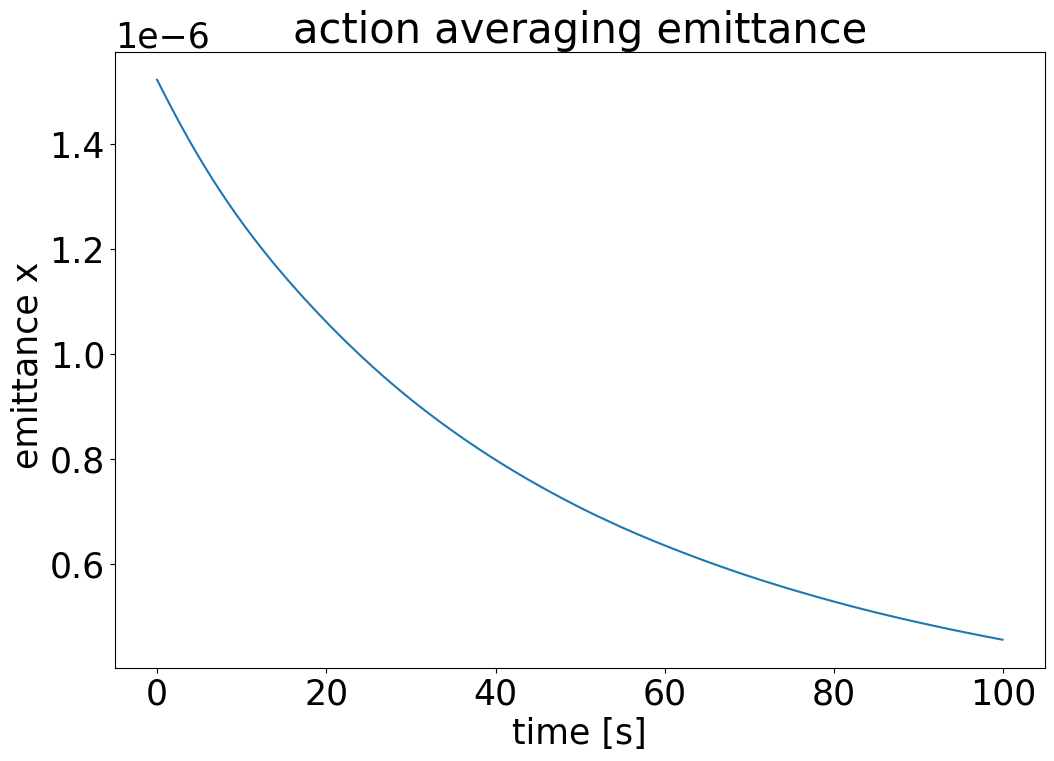

In [76]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,emittance_x_twiss)
plt.xlabel('time [s]')
plt.ylabel('emittance x ')
plt.title('action averaging emittance')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

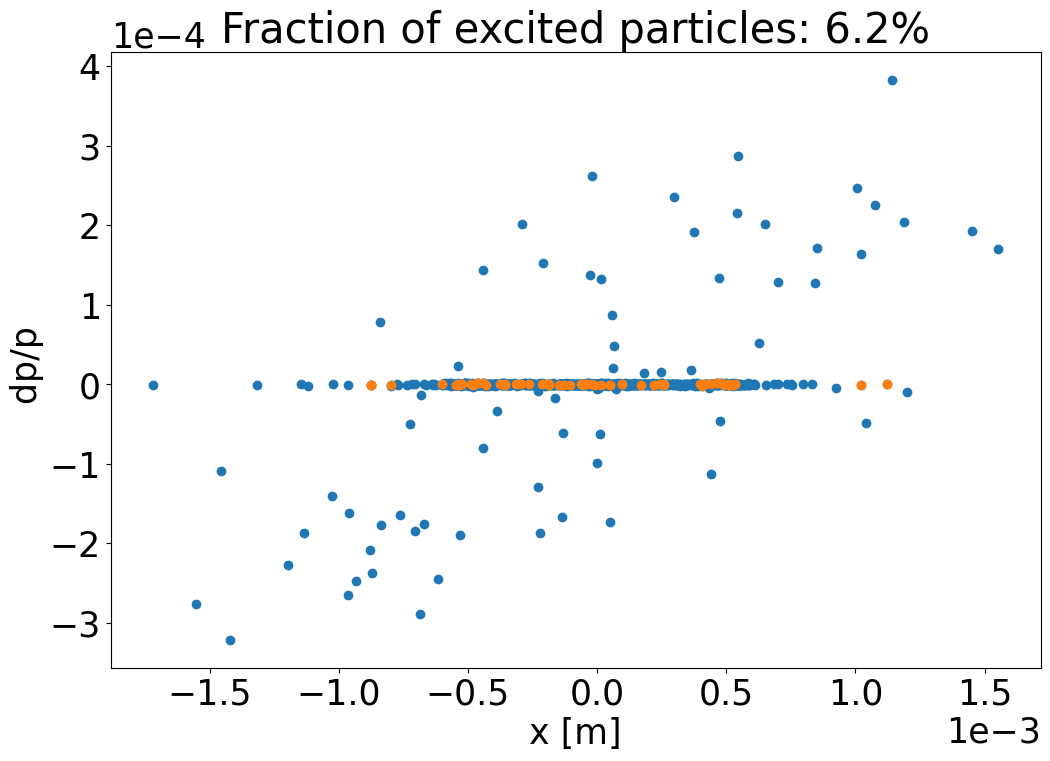

In [73]:
excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(x[-1,:],delta[-1,:])
plt.scatter(x[-1,:][excited],delta[-1,:][excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


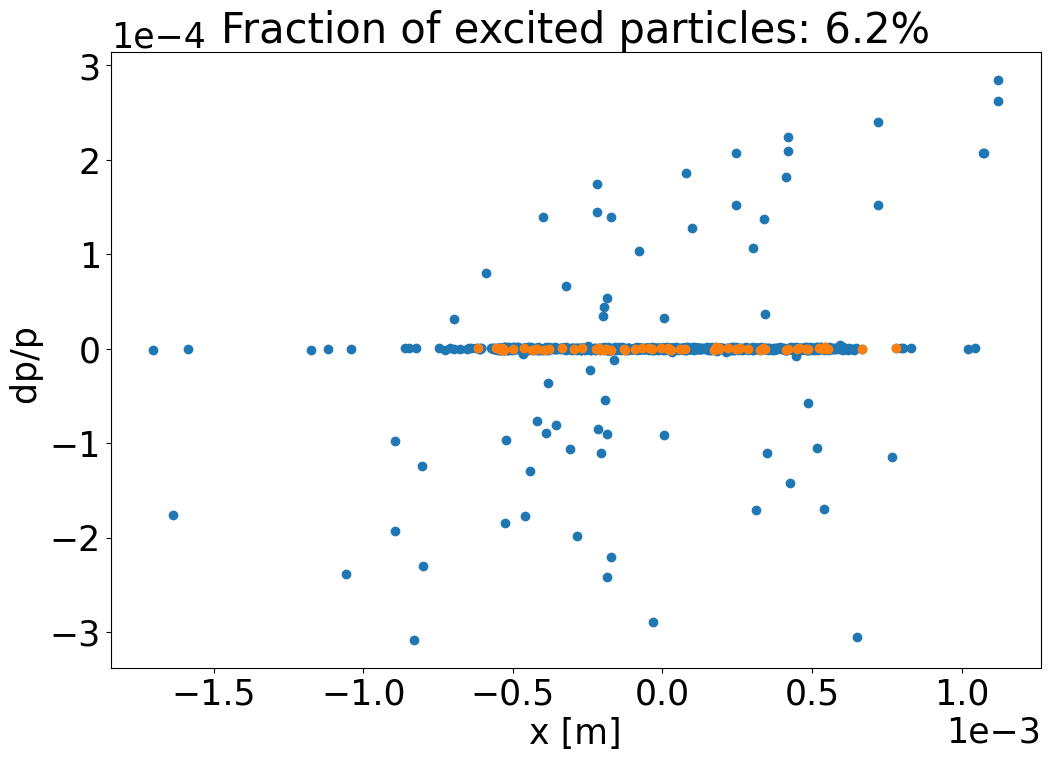

In [74]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

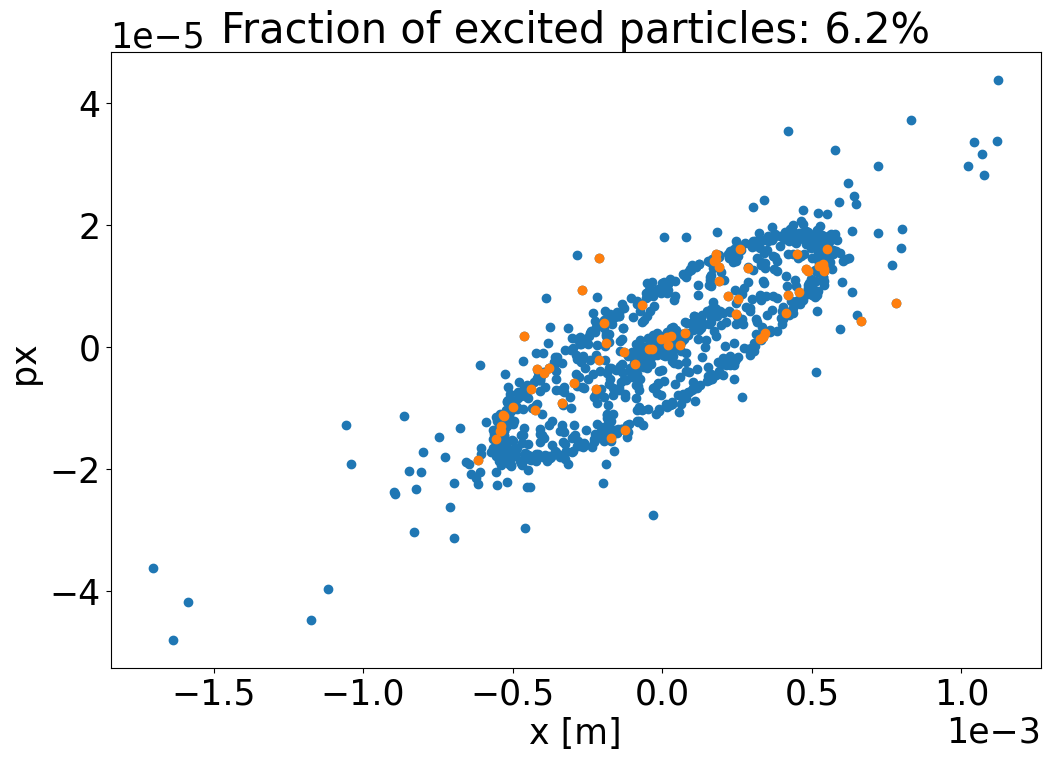

In [75]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()